In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import urllib
import zipfile

import geopandas as gpd
import seaborn as sns
sns.set(style="whitegrid")
import libpysal as lps
from libpysal.weights import Queen, Rook, KNN
import pysal as ps
import pysal.viz as viz
import numpy as np
import pandas as pd
import shapely.geometry
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline

import mapclassify
import warnings
warnings.simplefilter('ignore')

In [2]:
import esda

Read Data

In [3]:
gdf = gpd.read_file('data/lsoa_IMD20159.shp')
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA      4835 non-null   object  
 1   IMD2011   4765 non-null   float64 
 2   IMD2015   4835 non-null   float64 
 3   IMD2019   4835 non-null   float64 
 4   geometry  4835 non-null   geometry
dtypes: float64(3), geometry(1), object(1)
memory usage: 189.0+ KB


In [4]:
gdf2011 = gpd.read_file('data/lsoa_IMD2011.shp')
gdf2011.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4765 entries, 0 to 4764
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA      4765 non-null   object  
 1   IMD2011   4765 non-null   float64 
 2   geometry  4765 non-null   geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 111.8+ KB


Visualization

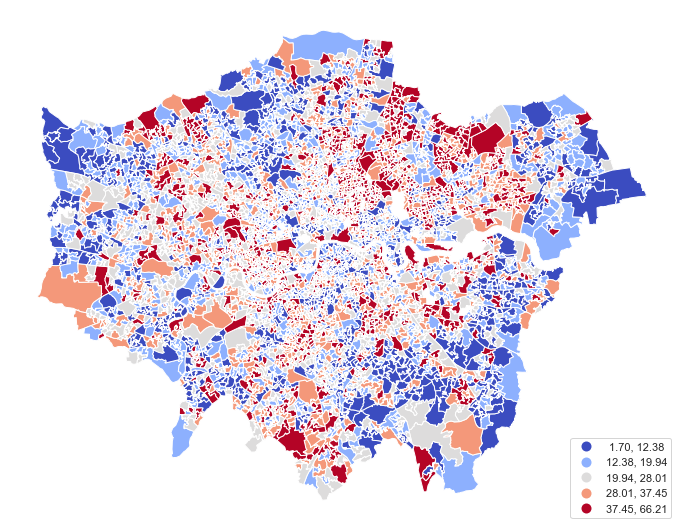

In [5]:
# 2011 IMD in London
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12,10))
# Plot Number of Airbnbs
# Quickly plot 
gdf2011.plot(column='IMD2011', cmap='coolwarm', scheme='Quantiles', legend=True, legend_kwds=dict(loc='lower right'), ax=ax)
# Remove axis frame
ax.set_axis_off()

plt.show()

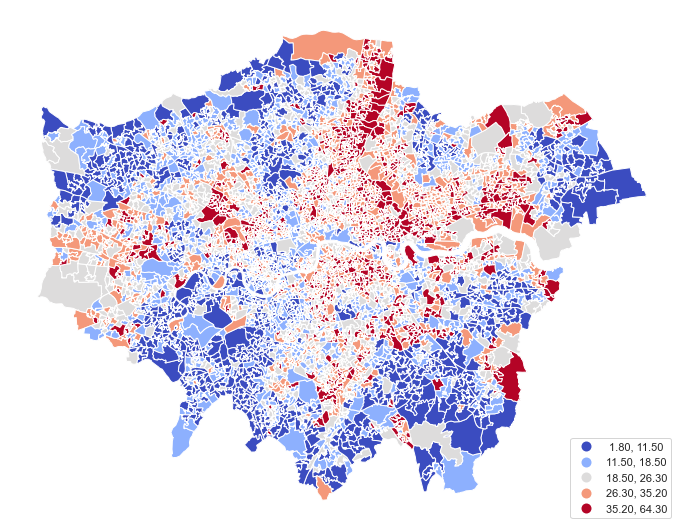

In [6]:
# 2015 IMD in London
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12,10))
# Plot Number of Airbnbs
# Quickly plot 
gdf.plot(column='IMD2015', cmap='coolwarm', scheme='Quantiles', legend=True, legend_kwds=dict(loc='lower right'), ax=ax)
# Remove axis frame
ax.set_axis_off()

plt.show()

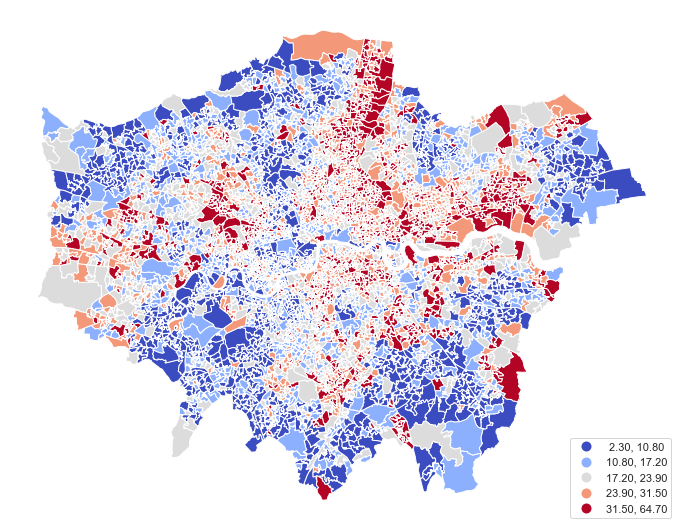

In [7]:
# 2019 IMD in London
f, ax = plt.subplots(1, figsize=(12,10))
# Plot Number of Airbnbs
# Quickly plot 
gdf.plot(column='IMD2019', cmap='coolwarm', scheme='Quantiles', legend=True, legend_kwds=dict(loc='lower right'), ax=ax)
# Remove axis frame
ax.set_axis_off()

plt.show()

Statistical Description

In [8]:
gdf2011['IMD2011'].describe()

count    4765.000000
mean       25.239815
std        13.244382
min         1.700000
25%        14.080000
50%        23.810000
75%        34.920000
max        66.210000
Name: IMD2011, dtype: float64

In [9]:
gdf['IMD2015'].describe()

count    4835.000000
mean       23.582834
std        12.436060
min         1.800000
25%        13.300000
50%        22.100000
75%        32.700000
max        64.300000
Name: IMD2015, dtype: float64

In [10]:
gdf['IMD2019'].describe()

count    4835.000000
mean       21.498676
std        10.904651
min         2.300000
25%        12.400000
50%        20.400000
75%        29.600000
max        64.700000
Name: IMD2019, dtype: float64

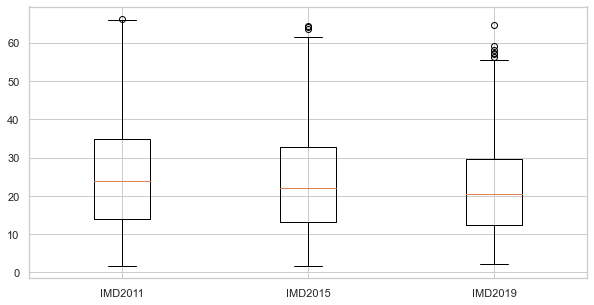

In [11]:
# IMD boxes
box_1, box_2, box_3 = gdf2011['IMD2011'], gdf['IMD2015'], gdf['IMD2019']
 
plt.figure(figsize=(10,5))
labels = 'IMD2011','IMD2015','IMD2019'
plt.boxplot([box_1, box_2, box_3], labels = labels)

plt.show()

Global Moran's I

In [12]:
w_queen = Queen.from_dataframe(gdf)
w_queen.transform = 'R'

In [13]:
mi2019 = esda.moran.Moran(gdf['IMD2019'], w_queen) # call moran function
mi2019.I # print out the moran's I value

0.6103760021195344

In [14]:
# Check the statistical significance
mi2019.p_sim

0.001

In [15]:
mi2015 = esda.moran.Moran(gdf['IMD2015'], w_queen) # call moran function
mi2015.I # print out the moran's I value

0.6321371064417228

In [16]:
# Check the statistical significance
mi2015.p_sim

0.001

In [17]:
w_queen2011 = Queen.from_dataframe(gdf2011)
w_queen2011.transform = 'R'

In [18]:
mi2011 = esda.moran.Moran(gdf2011['IMD2011'], w_queen2011) # call moran function
mi2011.I # print out the moran's I value

0.3982758648605977

In [19]:
# Check the statistical significance
mi2011.p_sim

0.001

Local spatial autocorrelation

In [20]:
lisa2019 = esda.Moran_Local(gdf['IMD2019'].values, w_queen, permutations=999)
(lisa2019.p_sim < 0.05).sum()

2207

In [21]:
lisa2015 = esda.Moran_Local(gdf['IMD2015'].values, w_queen, permutations=999)
(lisa2015.p_sim < 0.05).sum()

2238

In [22]:
lisa2011 = esda.Moran_Local(gdf2011['IMD2011'].values, w_queen2011, permutations=999)
(lisa2011.p_sim < 0.05).sum()

1592

LISA

In [23]:
gdf['lag_IMD2019'] = lps.weights.lag_spatial(w_queen, gdf['IMD2019'])
sigs = gdf['IMD2019'][lisa2019.p_sim <= .05]
W_sigs = gdf['lag_IMD2019'][lisa2019.p_sim <= .05]
insigs = gdf['IMD2019'][lisa2019.p_sim > .05]
W_insigs = gdf['lag_IMD2019'][lisa2019.p_sim > .05]

Text(0.5, 0, 'IMD2019')

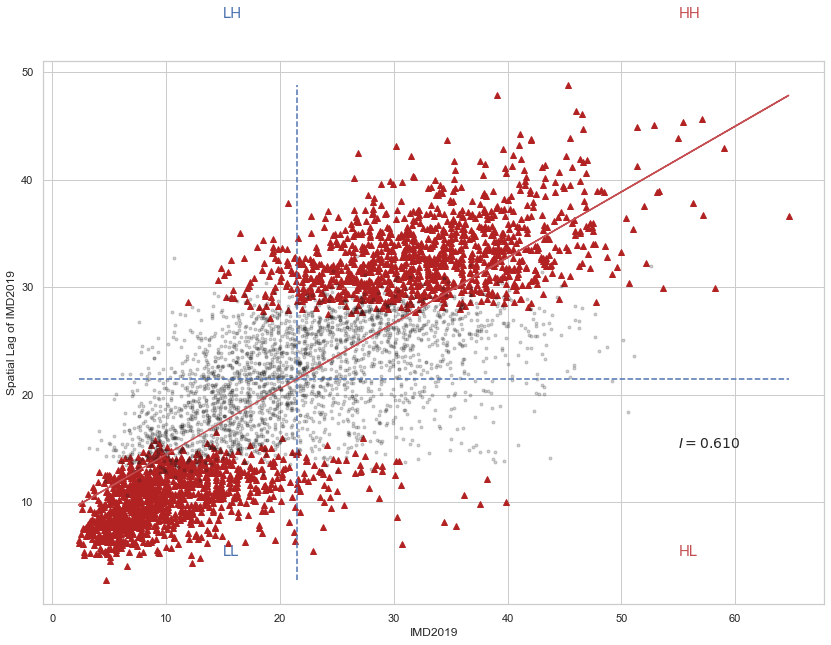

In [24]:
b,a = np.polyfit(gdf['IMD2019'], gdf['lag_IMD2019'], 1)

fig, ax=plt.subplots(1, figsize=(14,10))
plt.plot(sigs, W_sigs, '^', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(gdf['IMD2019'].mean(), gdf['lag_IMD2019'].min(), gdf['lag_IMD2019'].max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(gdf['lag_IMD2019'].mean(), gdf['IMD2019'].min(), gdf['IMD2019'].max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(gdf['IMD2019'], a + b*gdf['IMD2019'], 'r')
plt.text(s='$I = %.3f$' % mi2019.I, x=55, y=15, fontsize=14)
plt.text(55, 55, "HH", fontsize=15, color='r')
plt.text(55, 5, "HL", fontsize=15, color='r')
plt.text(15, 55, "LH", fontsize=15, color='b')
plt.text(15, 5, "LL", fontsize=15, color='b')
plt.ylabel('Spatial Lag of IMD2019')
plt.xlabel('IMD2019')

In [25]:
gdf['lag_IMD2015'] = lps.weights.lag_spatial(w_queen, gdf['IMD2015'])
sigs = gdf['IMD2015'][lisa2015.p_sim <= .05]
W_sigs = gdf['lag_IMD2015'][lisa2015.p_sim <= .05]
insigs = gdf['IMD2015'][lisa2015.p_sim > .05]
W_insigs = gdf['lag_IMD2015'][lisa2015.p_sim > .05]

Text(0.5, 0, 'IMD2015')

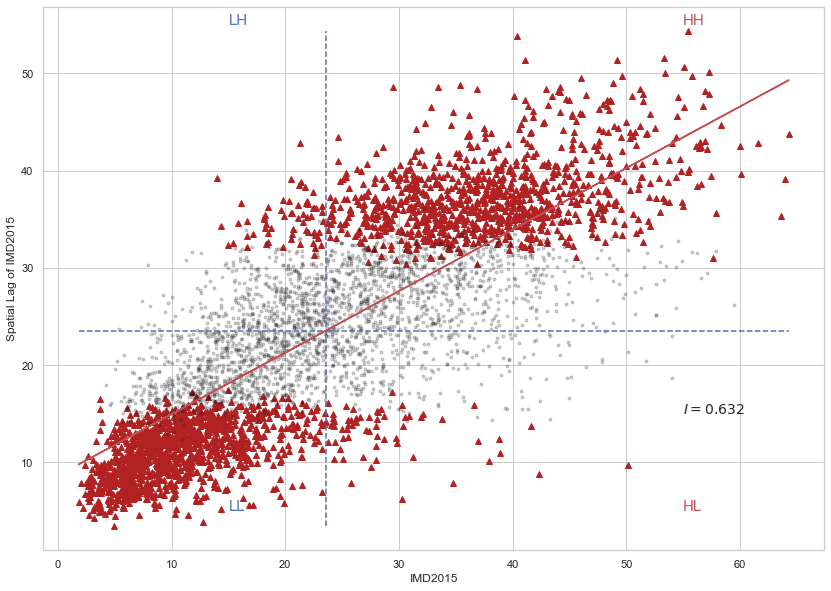

In [26]:
b,a = np.polyfit(gdf['IMD2015'], gdf['lag_IMD2015'], 1)

fig, ax=plt.subplots(1, figsize=(14,10))
plt.plot(sigs, W_sigs, '^', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(gdf['IMD2015'].mean(), gdf['lag_IMD2015'].min(), gdf['lag_IMD2015'].max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(gdf['lag_IMD2015'].mean(), gdf['IMD2015'].min(), gdf['IMD2015'].max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(gdf['IMD2015'], a + b*gdf['IMD2015'], 'r')
plt.text(s='$I = %.3f$' % mi2015.I, x=55, y=15, fontsize=14)
plt.text(55, 55, "HH", fontsize=15, color='r')
plt.text(55, 5, "HL", fontsize=15, color='r')
plt.text(15, 55, "LH", fontsize=15, color='b')
plt.text(15, 5, "LL", fontsize=15, color='b')
plt.ylabel('Spatial Lag of IMD2015')
plt.xlabel('IMD2015')

In [27]:
gdf2011['lag_IMD2011'] = lps.weights.lag_spatial(w_queen2011, gdf2011['IMD2011'])
sigs = gdf2011['IMD2011'][lisa2011.p_sim <= .05]
W_sigs = gdf2011['lag_IMD2011'][lisa2011.p_sim <= .05]
insigs = gdf2011['IMD2011'][lisa2011.p_sim > .05]
W_insigs = gdf2011['lag_IMD2011'][lisa2011.p_sim > .05]

Text(0.5, 0, 'IMD2011')

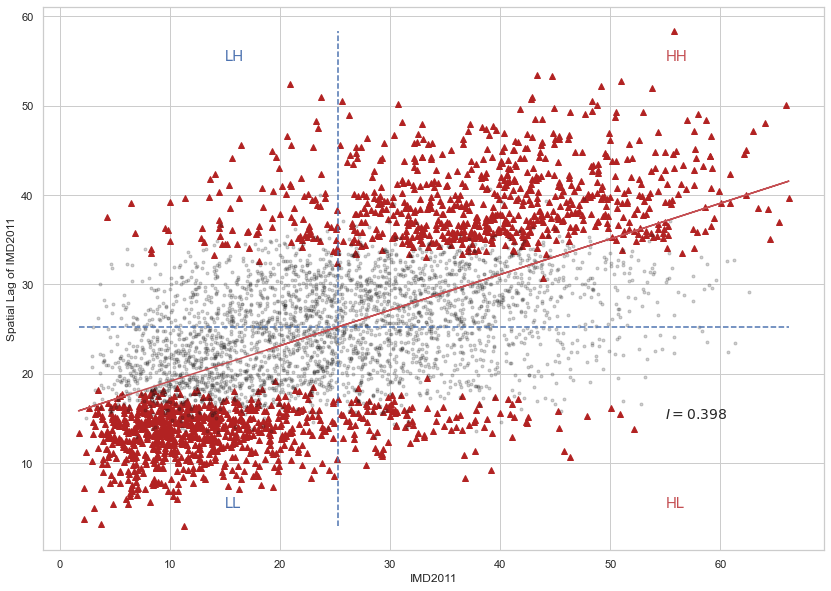

In [28]:
b,a = np.polyfit(gdf2011['IMD2011'], gdf2011['lag_IMD2011'], 1)

fig, ax=plt.subplots(1, figsize=(14,10))
plt.plot(sigs, W_sigs, '^', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(gdf2011['IMD2011'].mean(), gdf2011['lag_IMD2011'].min(), gdf2011['lag_IMD2011'].max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(gdf2011['lag_IMD2011'].mean(), gdf2011['IMD2011'].min(), gdf2011['IMD2011'].max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(gdf2011['IMD2011'], a + b*gdf2011['IMD2011'], 'r')
plt.text(s='$I = %.3f$' % mi2011.I, x=55, y=15, fontsize=14)
plt.text(55, 55, "HH", fontsize=15, color='r')
plt.text(55, 5, "HL", fontsize=15, color='r')
plt.text(15, 55, "LH", fontsize=15, color='b')
plt.text(15, 5, "LL", fontsize=15, color='b')
plt.ylabel('Spatial Lag of IMD2011')
plt.xlabel('IMD2011')

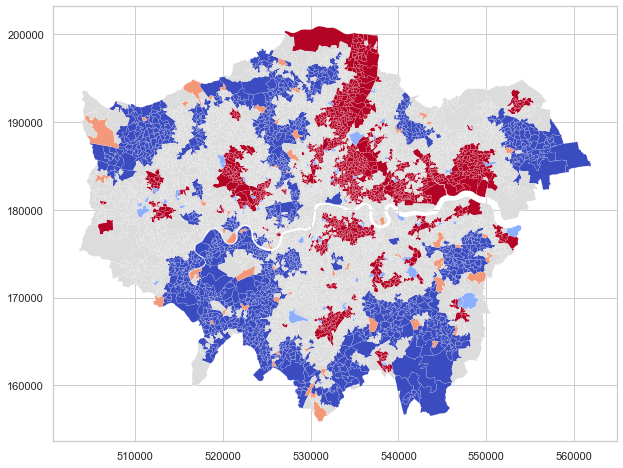

In [29]:
# LISA2019 Cluster Map
sig = lisa2019.p_sim < 0.05
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(12, 8))
# Plot building blocks
gdf.plot(ax=ax, facecolor='1', linewidth=0.1)
# Plot HH clusters
hh = gdf.loc[(lisa2019.q==1) & (sig==True), 'geometry']
hh.plot(ax=ax, color='#B40426', linewidth=0.1, edgecolor='w')
# Plot LL clusters
ll = gdf.loc[(lisa2019.q==3) & (sig==True), 'geometry']
ll.plot(ax=ax, color='#3B4CC0', linewidth=0.1, edgecolor='w')
# Plot LH clusters
lh = gdf.loc[(lisa2019.q==2) & (sig==True), 'geometry']
lh.plot(ax=ax, color='#8DB0FE', linewidth=0.1, edgecolor='w')
# Plot HL clusters
hl = gdf.loc[(lisa2019.q==4) & (sig==True), 'geometry']
hl.plot(ax=ax, color='#F4987A', linewidth=0.1, edgecolor='w')
# Non-significant
ns = gdf.loc[sig!=True, 'geometry']
ns.plot(ax=ax, color='#DDDCDC', linewidth=0.1, edgecolor='w')
# Style and draw
f.set_facecolor('w')
plt.show()

In [30]:
# Count the number of IMD samples identified as HH, LL, HL, LH, NS
print(len(ns), len(hh), len(ll), len(lh), len(hl))

2628 987 1095 64 61


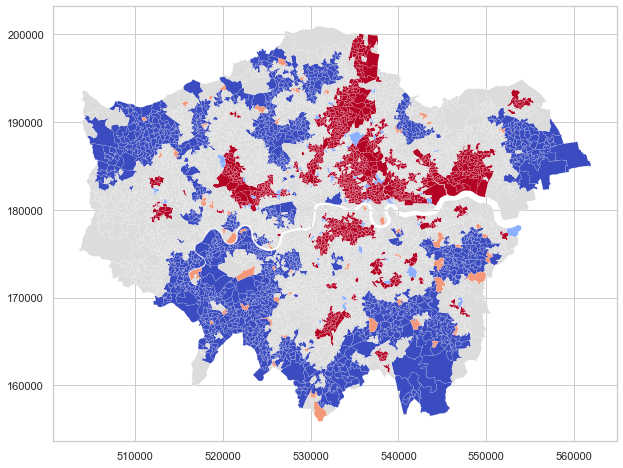

In [31]:
# LISA2015 Cluster Map
sig = lisa2015.p_sim < 0.05
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(12, 8))
# Plot building blocks
gdf.plot(ax=ax, facecolor='1', linewidth=0.1)
# Plot HH clusters
hh = gdf.loc[(lisa2015.q==1) & (sig==True), 'geometry']
hh.plot(ax=ax, color='#B40426', linewidth=0.1, edgecolor='w')
# Plot LL clusters
ll = gdf.loc[(lisa2015.q==3) & (sig==True), 'geometry']
ll.plot(ax=ax, color='#3B4CC0', linewidth=0.1, edgecolor='w')
# Plot LH clusters
lh = gdf.loc[(lisa2015.q==2) & (sig==True), 'geometry']
lh.plot(ax=ax, color='#8DB0FE', linewidth=0.1, edgecolor='w')
# Plot HL clusters
hl = gdf.loc[(lisa2015.q==4) & (sig==True), 'geometry']
hl.plot(ax=ax, color='#F4987A', linewidth=0.1, edgecolor='w')
# Non-significant
ns = gdf.loc[sig!=True, 'geometry']
ns.plot(ax=ax, color='#DDDCDC', linewidth=0.1, edgecolor='w')
# Style and draw
f.set_facecolor('w')
plt.show()

In [32]:
# Count the number of IMD samples identified as HH, LL, HL, LH, NS
print(len(ns), len(hh), len(ll), len(lh), len(hl))

2597 944 1172 61 61


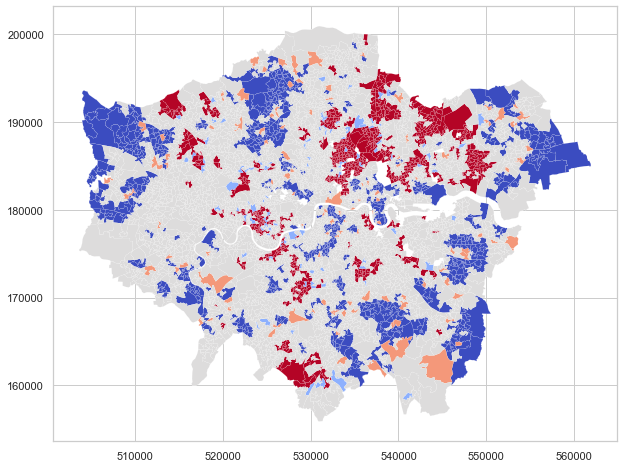

In [33]:
# LISA2011 Cluster Map
sig = lisa2011.p_sim < 0.05
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(12, 8))
# Plot building blocks
gdf.plot(ax=ax, facecolor='1', linewidth=0.1)
# Plot HH clusters
hh = gdf2011.loc[(lisa2011.q==1) & (sig==True), 'geometry']
hh.plot(ax=ax, color='#B40426', linewidth=0.1, edgecolor='w')
# Plot LL clusters
ll = gdf2011.loc[(lisa2011.q==3) & (sig==True), 'geometry']
ll.plot(ax=ax, color='#3B4CC0', linewidth=0.1, edgecolor='w')
# Plot LH clusters
lh = gdf2011.loc[(lisa2011.q==2) & (sig==True), 'geometry']
lh.plot(ax=ax, color='#8DB0FE', linewidth=0.1, edgecolor='w')
# Plot HL clusters
hl = gdf2011.loc[(lisa2011.q==4) & (sig==True), 'geometry']
hl.plot(ax=ax, color='#F4987A', linewidth=0.1, edgecolor='w')
# Non-significant
ns = gdf2011.loc[sig!=True, 'geometry']
ns.plot(ax=ax, color='#DDDCDC', linewidth=0.1, edgecolor='w')
# Style and draw
f.set_facecolor('w')
plt.show()

In [34]:
# Count the number of IMD samples identified as HH, LL, HL, LH, NS
print(len(ns), len(hh), len(ll), len(lh), len(hl))

3173 635 746 97 114
